In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from monai.transforms import Compose, LoadImaged, AddChanneld, ToTensord, EnsureChannelFirstd
import pandas as pd
import numpy as np
import random
from pathlib import Path

In [7]:
class AgePredictionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.subjects = df['Subject'].unique()

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        df_subject = self.df[self.df['Subject'] == subject]

        # select a random sample from this subject
        sample = df_subject.sample(n=1, random_state=np.random.randint(0,100))
        
        dir = Path(sample['dir'].values[0])
        img_fa = dir / 'dwmri%fa_brain_MNI152_linear.nii.gz'
        img_md = dir / 'dwmri%md_brain_MNI152_linear.nii.gz'
        dict_sex2numeric = {'female':0, 'male':1}
        sex = torch.tensor(dict_sex2numeric[sample['Sex'].values[0]], dtype=torch.float32)
        age = torch.tensor(sample['Age'].values[0], dtype=torch.float32)

        # Transform
        transform = Compose([
            LoadImaged(keys=['fa', 'md'], image_only=True),
            EnsureChannelFirstd(keys=['fa', 'md']),
            ToTensord(keys=['fa', 'md'])
        ])
        data_dict = {'fa': img_fa, 'md': img_md}
        data_dict = transform(data_dict)
        
        return data_dict['fa'], data_dict['md'], sex, age

In [8]:
df = pd.read_csv('../data/train.csv')
len(df['Subject'].unique())

1018

In [16]:
df_train = pd.read_csv('../data/train.csv')
dataset = AgePredictionDataset(df_train)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
for fa, md, sex, age in dataloader:
    break
print("fa: {}\nmd: {}\nsex: {}\nage: {}".format(fa.shape, md.shape, sex.shape, age.shape))

fa: torch.Size([8, 1, 193, 229, 193])
md: torch.Size([8, 1, 193, 229, 193])
sex: torch.Size([8])
age: torch.Size([8])


In [17]:
sex

tensor([1., 0., 1., 1., 0., 1., 1., 0.])

In [29]:
sex.size(0)

8

In [19]:
sex = sex.view(sex.size(0), -1)
sex.shape

torch.Size([8, 1])

In [26]:
new = torch.concat((sex,sex,sex), dim=1)
new.shape

torch.Size([8, 3])

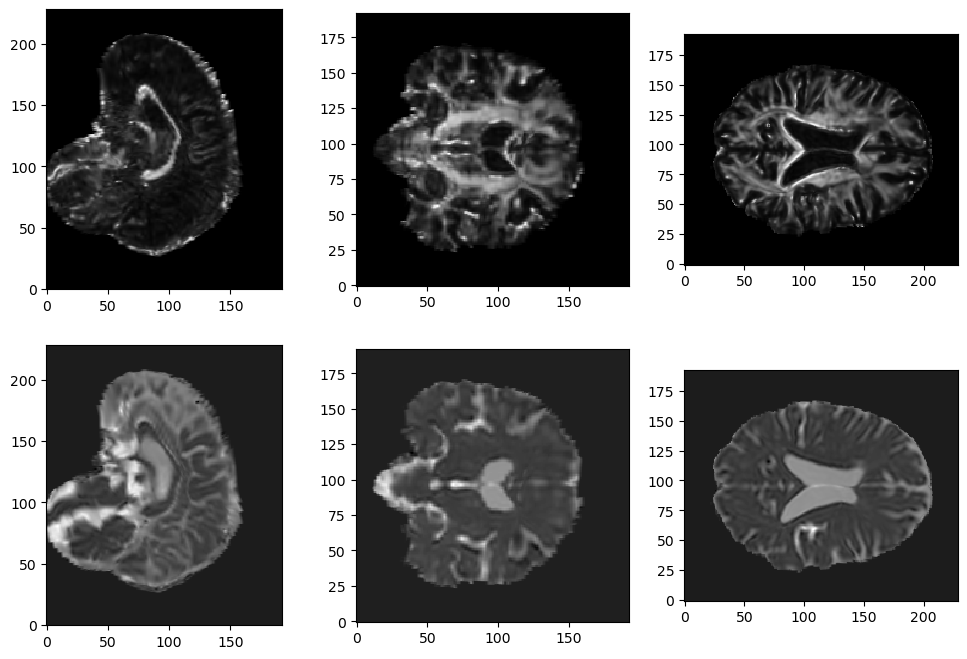

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0,0].imshow(fa[0,0,round(fa.shape[2]/2),:,:], cmap='gray', origin='lower', interpolation='nearest')
axes[0,1].imshow(fa[0,0,:,round(fa.shape[3]/2),:], cmap='gray', origin='lower', interpolation='nearest')
axes[0,2].imshow(fa[0,0,:,:,round(fa.shape[4]/2)], cmap='gray', origin='lower', interpolation='nearest')

axes[1,0].imshow(md[0,0,round(fa.shape[2]/2),:,:], cmap='gray', origin='lower', interpolation='nearest')
axes[1,1].imshow(md[0,0,:,round(fa.shape[3]/2),:], cmap='gray', origin='lower', interpolation='nearest')
axes[1,2].imshow(md[0,0,:,:,round(fa.shape[4]/2)], cmap='gray', origin='lower', interpolation='nearest')